In [1]:
%pip install -qU sagemaker boto3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.11.2 requires botocore<1.34.35,>=1.33.2, but you have botocore 1.34.100 which is incompatible.
anthropic-bedrock 0.4.0 requires anyio<4,>=3.5.0, but you have anyio 4.2.0 which is incompatible.


In [ ]:
!bash build_and_push.sh

In [59]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

import boto3

account_id = boto3.client("sts").get_caller_identity().get("Account")
region_name = boto3.session.Session().region_name

In [60]:
suffix = "com"
if region_name.startswith('cn'):
    suffix = "com.cn"
    
model_name = None
image_uri = "{0}.dkr.ecr.{1}.amazonaws.{2}/story-diffusion-inference-api:latest".format(
    account_id, region_name,suffix
)
base_name = sagemaker.utils.base_name_from_image(image_uri)
image_uri

'434444145045.dkr.ecr.us-east-1.amazonaws.com/story-diffusion-inference-api:latest'

In [61]:
!touch dummy
!tar czvf model.tar.gz dummy
model_data = 's3://{0}/{1}/model.tar.gz'.format(bucket, 'story-diffusion')
!aws s3 cp model.tar.gz $model_data
!rm -f dummy model.tar.gz

dummy
upload: ./model.tar.gz to s3://sagemaker-us-east-1-434444145045/story-diffusion/model.tar.gz


In [81]:
from sagemaker.model import Model
from sagemaker.predictor import Predictor

model = Model(
    name=model_name,
    model_data=model_data,
    role=role,
    image_uri=image_uri,
    predictor_cls=Predictor,
)

In [82]:
instance_type = "ml.g5.4xlarge"
instance_count = 1

## Async deployment

In [149]:
from sagemaker.async_inference import AsyncInferenceConfig
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
output_path="s3://{0}/{1}/asyncinvoke/out/".format(bucket, "story-diffusion")
input_path="s3://{0}/{1}/asyncinvoke/in/".format(bucket, "story-diffusion")
async_config = AsyncInferenceConfig(
    output_path=output_path
)

In [116]:
predictor = model.deploy(
    instance_type=instance_type,
    initial_instance_count=instance_count,
    container_startup_health_check_timeout=1200,
    async_inference_config=async_config,
)

--------------!

In [135]:
print(predictor.endpoint_name)

story-diffusion-inference-api-2024-05-09-14-01-03-497


In [136]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

inputs = {
  "general_prompt": "a boy",
  "negative_prompt": "naked, deformed, bad anatomy, disfigured, poorly drawn face, mutation, extra limb, ugly, disgusting, poorly drawn hands, missing limb, floating limbs, disconnected limbs, blurry, watermarks, oversaturated, distorted hands, amputation",
  "prompt_array": "Zane's peaceful village life is disrupted when he and his friend Mara venture into the nearby woods, leading to an unexpected turn of events.\nZane and his friend discover an ancient, weathered book hidden in the forest.",
   "style": "Japanese Anime",
    "G_height":768,
    "G_width":768,
}


In [137]:

# prediction = predictor.predict(inputs)
prediction = predictor.predict_async(inputs)

In [138]:
import json
import io

s3_resource = boto3.resource("s3")


def get_bucket_and_key(s3uri):
    pos = s3uri.find("/", 5)
    bucket = s3uri[5:pos]
    key = s3uri[pos + 1 :]
    return bucket, key

In [193]:
from sagemaker.async_inference.waiter_config import WaiterConfig

print(f"Response object: {prediction}")
print(f"Response output path: {prediction.output_path}")
print("Start Polling to get response:")

import time
start = time.time()
config = WaiterConfig(
    max_attempts=100, delay=10  #  number of attempts  #  time in seconds to wait between attempts
)
prediction.get_result(config)

print(f"Time taken: {time.time() - start}s")

Response object: <sagemaker.async_inference.async_inference_response.AsyncInferenceResponse object at 0x7fce33775690>
Response output path: s3://sagemaker-us-east-1-434444145045/story-diffusion/asyncinvoke/out/399c7fb5-a581-42a2-8306-acf884bc6649.out
Start Polling to get response:
Time taken: 8.153915405273438e-05s


In [194]:
from io import BytesIO
import base64
from PIL import Image

def base64_to_image(base64_string):
    image_bytes = base64.b64decode(base64_string)
    image_buffer = BytesIO(image_bytes)
    image = Image.open(image_buffer)
    return image

In [240]:
import traceback
from PIL import Image
import uuid
from datetime import datetime

def get_async_result(prediction):
    images = []
    try:
        output_bucket, output_key = get_bucket_and_key(prediction.output_path)
        output_obj = s3_resource.Object(output_bucket, output_key)
        body = output_obj.get()["Body"].read().decode("utf-8")
        respobj = json.loads(body)
        for img in respobj['images_base64']:
            images.append(base64_to_image(img))
    except Exception as e:
        traceback.print_exc()
        print(e)
    return images
    

In [241]:
imgs = get_async_result(prediction)

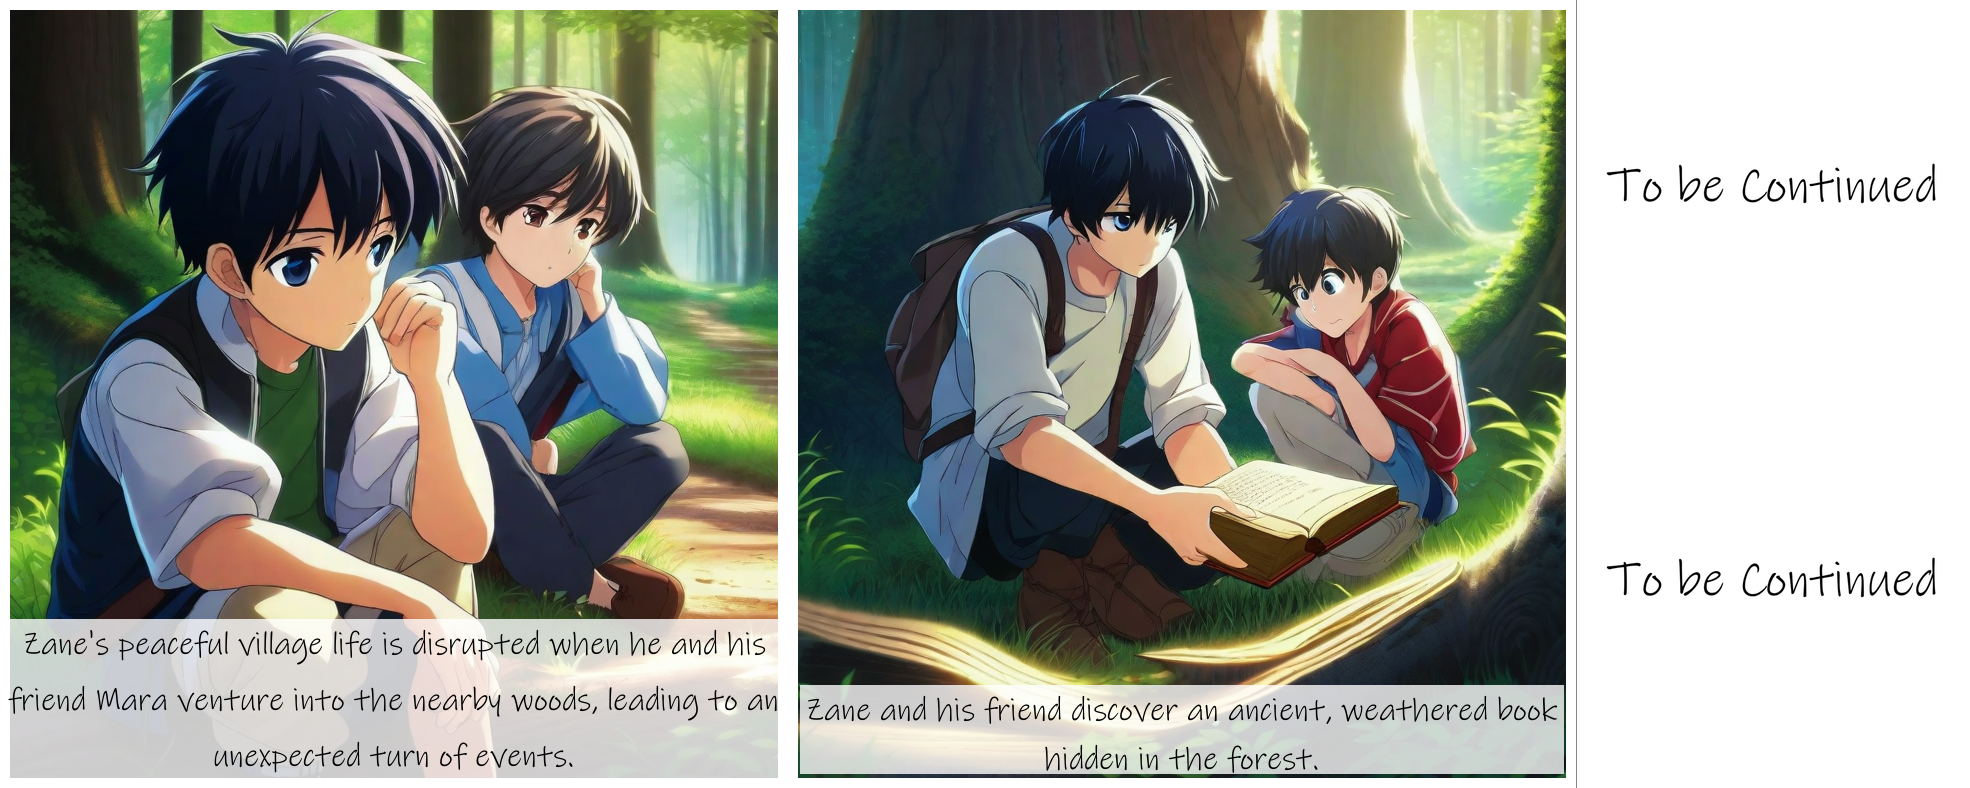

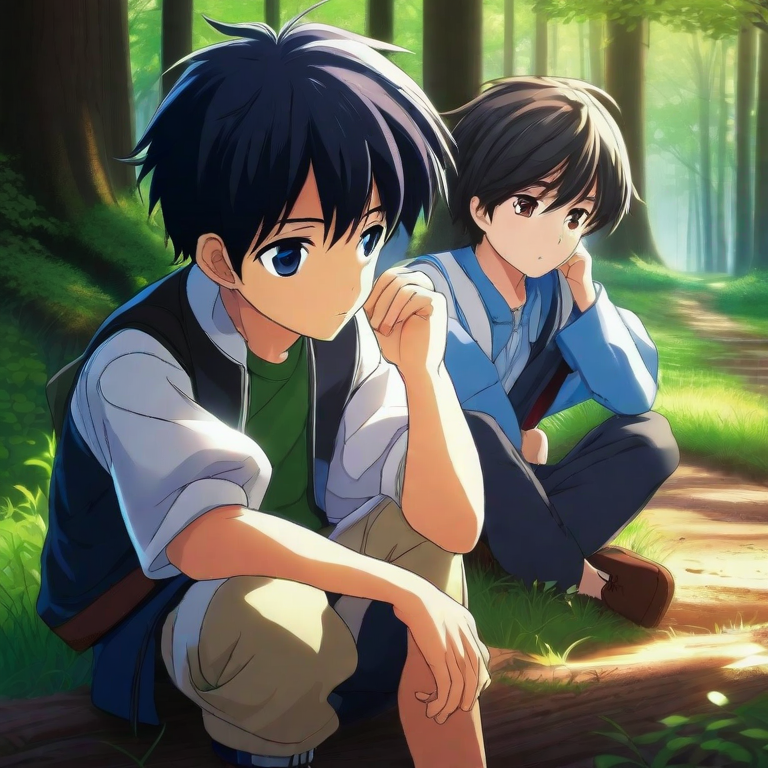

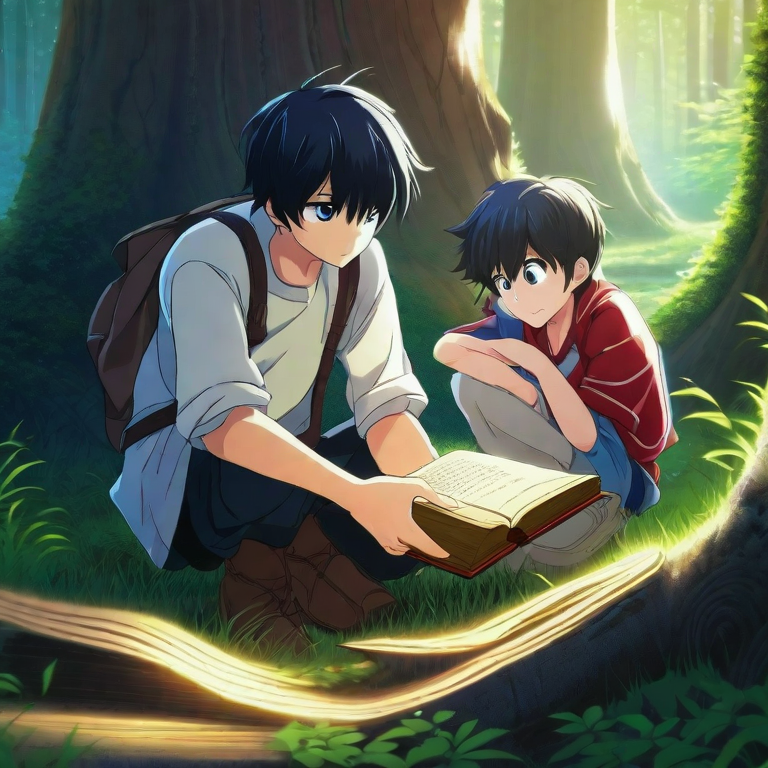

In [242]:
for img in imgs:
    img.show()